In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_19_02_45
NN-MODEL FILENAME:  ./models/VBKG0BIX_19_02_45_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-4  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 20000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1258.78 MiB, increment: 1038.96 MiB
Quantization TIME:  0.02 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15558
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 61
TOTAL SERIAL TIMESTEPS:   15558
TOTAL PARALLEL TIMESTEPS: 61


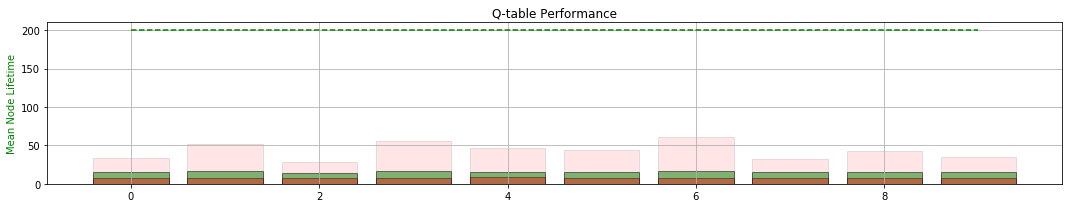

MEMORY COUNTER:  15558
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 624.241	LOSS : 600.516	LOSS : 635.032	LOSS : 588.245	LOSS : 610.574	LOSS : 573.134	LOSS : 594.320	LOSS : 550.615	
Validating... MEAN TIME:  21.59
LOSS : 542.194	LOSS : 550.035	LOSS : 568.529	LOSS : 555.182	LOSS : 549.828	LOSS : 541.816	LOSS : 538.100	LOSS : 515.535	
Validating... MEAN TIME:  9.435
LOSS : 524.628	LOSS : 527.777	LOSS : 504.086	LOSS : 517.717	LOSS : 513.627	LOSS : 526.816	LOSS : 518.406	LOSS : 506.994	
Validating... MEAN TIME:  9.29
LOSS : 522.741	LOSS : 523.741	LOSS : 520.820	LOSS : 538.378	LOSS : 517.404	LOSS : 523.031	LOSS : 523.345	LOSS : 515.600	
Validating... MEAN TIME:  9.375
LOSS : 513.155	LOSS : 539.857	LOSS : 523.693	LOSS : 520.879	LOSS : 529.485	LOSS : 510.819	LOSS : 529.133	LOSS : 507.206	
Validating... MEAN TIME:  9.3
TRAINING TIME:0:00:27.087966


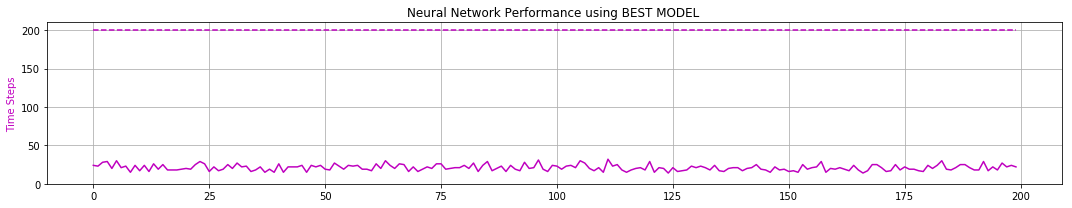

peak memory: 1322.36 MiB, increment: 1046.02 MiB
0 -max- [ 0.338  2.159  0.206  1.734]
0 -min- [-0.154 -1.207 -0.209 -2.916]

1 -max- [ 0.364  1.986  0.203  1.216]
1 -min- [-0.126 -0.943 -0.209 -2.766]

2 -max- [ 0.249  1.803  0.204  1.669]
2 -min- [-0.173 -1.027 -0.209 -2.749]

3 -max- [ 0.910  3.634  0.207  2.169]
3 -min- [-0.185 -1.331 -0.209 -3.350]

4 -max- [ 0.590  2.667  0.207  1.767]
4 -min- [-0.108 -0.981 -0.209 -2.742]

5 -max- [ 0.355  2.262  0.207  1.775]
5 -min- [-0.162 -1.120 -0.209 -2.747]

6 -max- [ 0.756  2.327  0.201  1.385]
6 -min- [-0.126 -0.976 -0.209 -3.012]

7 -max- [ 0.258  2.080  0.206  1.026]
7 -min- [-0.058 -0.627 -0.209 -2.751]

8 -max- [ 0.216  1.797  0.196  1.515]
8 -min- [-0.297 -1.496 -0.209 -2.726]

9 -max- [ 0.272  2.465  0.195  2.014]
9 -min- [-0.163 -1.167 -0.208 -2.961]

Quantization TIME:  0.02 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   19704
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 103
TOTAL SERIAL TIMESTEPS:   35262
TOTAL PARALLEL TIME

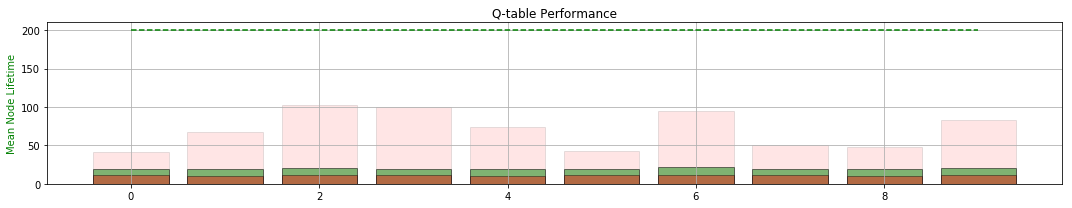

MEMORY COUNTER:  35262
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 495.884	LOSS : 504.628	LOSS : 508.796	LOSS : 477.400	LOSS : 503.525	LOSS : 498.918	LOSS : 492.391	LOSS : 492.338	
Validating... MEAN TIME:  24.01
LOSS : 526.304	LOSS : 490.706	LOSS : 497.922	LOSS : 479.497	LOSS : 484.561	LOSS : 492.179	LOSS : 493.767	LOSS : 485.618	
Validating... MEAN TIME:  131.95
LOSS : 477.524	LOSS : 467.510	LOSS : 457.295	LOSS : 469.471	LOSS : 468.283	LOSS : 500.448	LOSS : 486.040	LOSS : 472.755	
Validating... MEAN TIME:  76.945
LOSS : 480.234	LOSS : 490.060	LOSS : 477.252	LOSS : 470.027	LOSS : 472.977	LOSS : 468.036	LOSS : 472.139	LOSS : 513.971	
Validating... MEAN TIME:  68.2
LOSS : 459.936	LOSS : 494.901	LOSS : 481.592	LOSS : 471.928	LOSS : 465.800	LOSS : 452.381	LOSS : 459.701	LOSS : 487.643	
Validating... MEAN TIME:  80.22
TRAINING TIME:0:00:38.835945


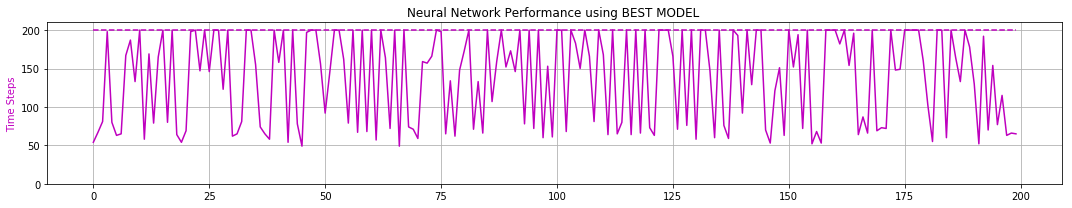

peak memory: 1354.33 MiB, increment: 1037.29 MiB
0 -max- [ 0.061  0.434  0.209  2.143]
0 -min- [-0.251 -1.322 -0.067 -0.617]

1 -max- [ 0.075  0.441  0.209  2.070]
1 -min- [-0.463 -1.409 -0.197 -1.353]

2 -max- [ 0.085  0.617  0.209  2.495]
2 -min- [-2.073 -3.200 -0.208 -1.003]

3 -max- [ 0.052  0.402  0.209  2.213]
3 -min- [-1.744 -2.866 -0.141 -0.662]

4 -max- [ 0.111  1.010  0.209  1.820]
4 -min- [-0.504 -1.152 -0.190 -1.690]

5 -max- [ 0.067  0.589  0.209  2.055]
5 -min- [-0.203 -1.391 -0.070 -0.817]

6 -max- [ 0.195  0.782  0.209  2.176]
6 -min- [-1.596 -2.828 -0.199 -1.280]

7 -max- [ 0.061  0.633  0.209  1.834]
7 -min- [-0.274 -1.186 -0.061 -0.917]

8 -max- [ 0.051  0.528  0.209  1.779]
8 -min- [-0.253 -1.205 -0.071 -0.625]

9 -max- [ 0.080  0.553  0.209  2.050]
9 -min- [-0.725 -1.214 -0.209 -1.015]

Quantization TIME:  0.02 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   81397
SMALLEST TIMESTEP: 14
LARGEST  TIMESTEP: 193
TOTAL SERIAL TIMESTEPS:   116659
TOTAL PARALLEL TIM

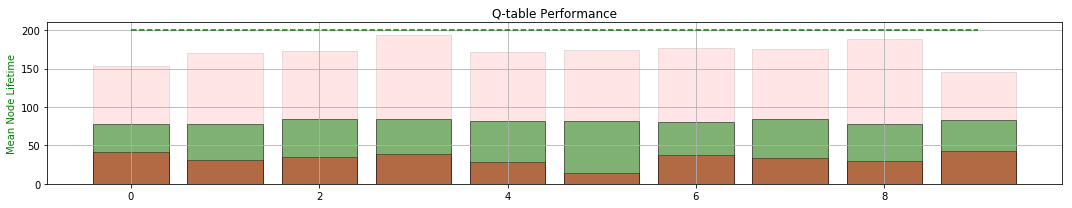

MEMORY COUNTER:  116659
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 240.978	LOSS : 231.256	LOSS : 234.511	LOSS : 233.810	LOSS : 221.934	LOSS : 252.302	LOSS : 226.936	LOSS : 242.467	
Validating... MEAN TIME:  74.035
LOSS : 235.986	LOSS : 239.957	LOSS : 220.941	LOSS : 237.111	LOSS : 238.052	LOSS : 221.361	LOSS : 236.669	LOSS : 237.484	
Validating... MEAN TIME:  101.02
LOSS : 221.191	LOSS : 219.453	LOSS : 246.920	LOSS : 235.929	LOSS : 227.335	LOSS : 245.227	LOSS : 237.240	LOSS : 217.125	
Validating... MEAN TIME:  115.715
LOSS : 228.499	LOSS : 239.174	LOSS : 215.599	LOSS : 224.966	LOSS : 230.917	LOSS : 227.923	LOSS : 225.942	LOSS : 219.685	
Validating... MEAN TIME:  127.16
LOSS : 229.052	LOSS : 222.352	LOSS : 243.160	LOSS : 236.551	LOSS : 234.280	LOSS : 231.696	LOSS : 218.674	LOSS : 236.532	
Validating... MEAN TIME:  128.565
TRAINING TIME:0:00:46.050554


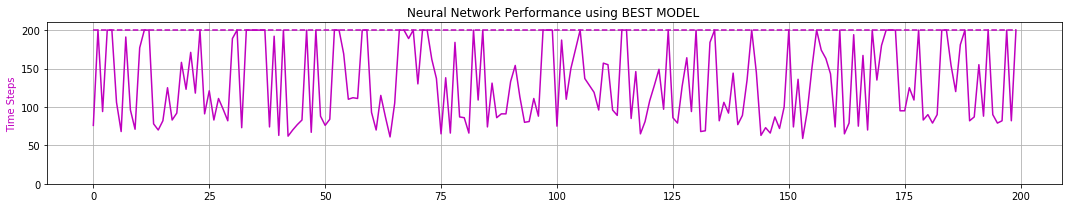

peak memory: 1396.60 MiB, increment: 1037.59 MiB
0 -max- [ 0.267  0.964  0.209  1.367]
0 -min- [-0.442 -1.115 -0.209 -1.422]

1 -max- [ 0.272  0.958  0.209  1.390]
1 -min- [-0.383 -1.318 -0.209 -1.497]

2 -max- [ 0.275  0.936  0.209  1.250]
2 -min- [-0.330 -0.928 -0.209 -1.437]

3 -max- [ 0.291  0.918  0.209  1.360]
3 -min- [-0.358 -0.898 -0.209 -1.164]

4 -max- [ 0.295  0.952  0.209  1.499]
4 -min- [-0.350 -1.120 -0.209 -1.510]

5 -max- [ 0.308  1.101  0.209  1.561]
5 -min- [-0.413 -0.995 -0.209 -1.582]

6 -max- [ 0.291  0.905  0.209  1.637]
6 -min- [-0.334 -1.061 -0.209 -1.149]

7 -max- [ 0.287  0.939  0.209  1.350]
7 -min- [-0.388 -0.932 -0.209 -1.430]

8 -max- [ 0.296  0.956  0.209  1.492]
8 -min- [-0.355 -0.930 -0.209 -1.251]

9 -max- [ 0.344  1.142  0.209  1.733]
9 -min- [-0.329 -0.944 -0.209 -1.355]

Quantization TIME:  0.01 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   69745
SMALLEST TIMESTEP: 38
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   186404
TOTAL PARALLEL TIM

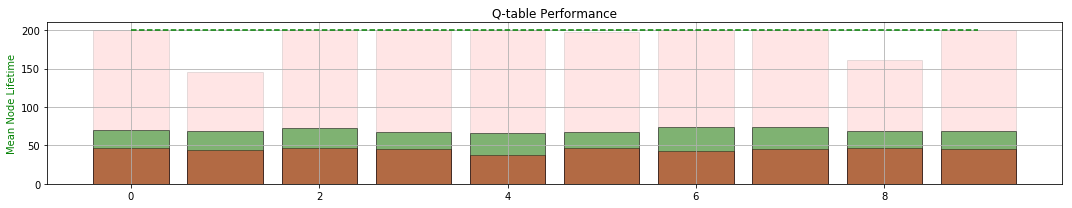

MEMORY COUNTER:  186404
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 183.794	LOSS : 201.548	LOSS : 185.145	LOSS : 192.425	LOSS : 182.465	LOSS : 200.865	LOSS : 208.269	LOSS : 180.615	
Validating... MEAN TIME:  119.275
LOSS : 178.387	LOSS : 194.822	LOSS : 183.389	LOSS : 191.288	LOSS : 191.307	LOSS : 204.303	LOSS : 199.663	LOSS : 202.750	
Validating... MEAN TIME:  123.845
LOSS : 185.310	LOSS : 179.188	LOSS : 195.915	LOSS : 188.282	LOSS : 203.676	LOSS : 201.178	LOSS : 212.908	LOSS : 221.151	
Validating... MEAN TIME:  129.875
LOSS : 194.384	LOSS : 183.344	LOSS : 192.728	LOSS : 183.392	LOSS : 196.333	LOSS : 182.156	LOSS : 186.419	LOSS : 178.062	
Validating... MEAN TIME:  131.67
LOSS : 183.434	LOSS : 185.747	LOSS : 185.872	LOSS : 211.413	LOSS : 196.218	LOSS : 178.258	LOSS : 209.335	LOSS : 193.892	
Validating... MEAN TIME:  115.81
TRAINING TIME:0:00:49.921583


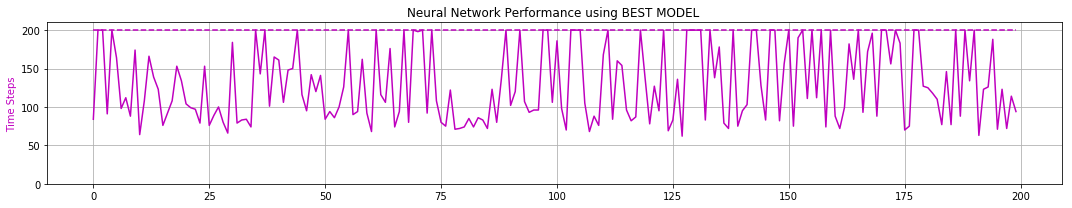

peak memory: 1401.77 MiB, increment: 998.38 MiB
0 -max- [ 0.458  0.772  0.208  1.102]
0 -min- [-0.365 -1.251 -0.209 -0.806]

1 -max- [ 0.480  1.047  0.209  0.791]
1 -min- [-0.363 -1.136 -0.209 -0.799]

2 -max- [ 0.474  0.945  0.209  0.800]
2 -min- [-0.372 -1.265 -0.209 -0.803]

3 -max- [ 0.459  0.781  0.209  0.805]
3 -min- [-0.385 -1.269 -0.209 -0.964]

4 -max- [ 0.486  0.952  0.209  0.802]
4 -min- [-0.391 -1.241 -0.209 -0.923]

5 -max- [ 0.487  0.951  0.209  0.773]
5 -min- [-0.386 -1.236 -0.209 -0.749]

6 -max- [ 0.462  0.948  0.209  1.030]
6 -min- [-0.385 -1.255 -0.209 -0.792]

7 -max- [ 0.454  0.930  0.209  0.799]
7 -min- [-0.379 -1.265 -0.209 -0.776]

8 -max- [ 0.464  0.869  0.209  0.808]
8 -min- [-0.409 -1.279 -0.209 -0.838]

9 -max- [ 0.456  0.957  0.209  0.806]
9 -min- [-0.374 -1.315 -0.209 -0.986]

Quantization TIME:  0.02 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   75114
SMALLEST TIMESTEP: 43
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   261518
TOTAL PARALLEL TIME

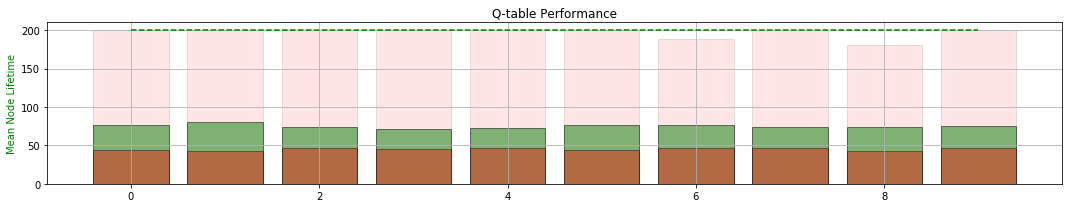

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 135.040	LOSS : 134.418	LOSS : 132.534	LOSS : 131.342	LOSS : 124.021	LOSS : 132.595	LOSS : 134.932	LOSS : 132.984	
Validating... MEAN TIME:  97.695
LOSS : 126.996	LOSS : 133.317	LOSS : 127.478	LOSS : 130.778	LOSS : 130.488	LOSS : 125.154	LOSS : 134.376	LOSS : 131.106	
Validating... MEAN TIME:  92.46
LOSS : 147.434	LOSS : 129.304	LOSS : 130.642	LOSS : 134.346	LOSS : 126.620	LOSS : 136.900	LOSS : 135.215	LOSS : 132.860	
Validating... MEAN TIME:  89.035
LOSS : 134.641	LOSS : 137.058	LOSS : 130.257	LOSS : 119.354	LOSS : 130.277	LOSS : 130.063	LOSS : 126.127	LOSS : 126.528	
Validating... MEAN TIME:  99.7
LOSS : 116.825	LOSS : 134.474	LOSS : 124.950	LOSS : 138.163	LOSS : 135.141	LOSS : 134.141	LOSS : 125.149	LOSS : 134.520	
Validating... MEAN TIME:  89.33
TRAINING TIME:0:00:43.929963


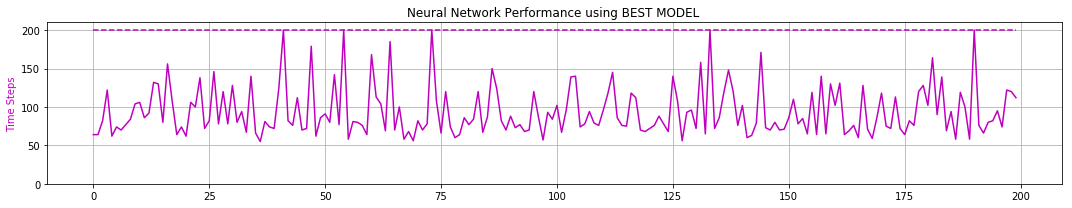

peak memory: 1400.96 MiB, increment: 978.86 MiB
0 -max- [ 0.446  0.955  0.209  0.893]
0 -min- [-0.486 -1.310 -0.209 -0.801]

1 -max- [ 0.445  0.770  0.209  1.128]
1 -min- [-0.493 -1.326 -0.209 -0.802]

2 -max- [ 0.465  0.915  0.208  0.803]
2 -min- [-0.493 -1.477 -0.209 -0.818]

3 -max- [ 0.504  0.790  0.209  0.793]
3 -min- [-0.492 -1.334 -0.209 -0.929]

4 -max- [ 0.439  0.858  0.208  0.792]
4 -min- [-0.498 -1.300 -0.209 -0.797]

5 -max- [ 0.440  0.774  0.209  1.060]
5 -min- [-0.506 -1.309 -0.209 -0.845]

6 -max- [ 0.436  0.764  0.209  1.080]
6 -min- [-0.502 -1.291 -0.209 -0.824]

7 -max- [ 0.434  0.763  0.209  0.800]
7 -min- [-0.483 -1.291 -0.209 -0.757]

8 -max- [ 0.452  0.885  0.208  0.792]
8 -min- [-0.475 -1.313 -0.209 -1.026]

9 -max- [ 0.431  0.779  0.209  0.797]
9 -min- [-0.467 -1.290 -0.209 -0.838]

Quantization TIME:  0.02 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   64375
SMALLEST TIMESTEP: 34
LARGEST  TIMESTEP: 187
TOTAL SERIAL TIMESTEPS:   325893
TOTAL PARALLEL TIME

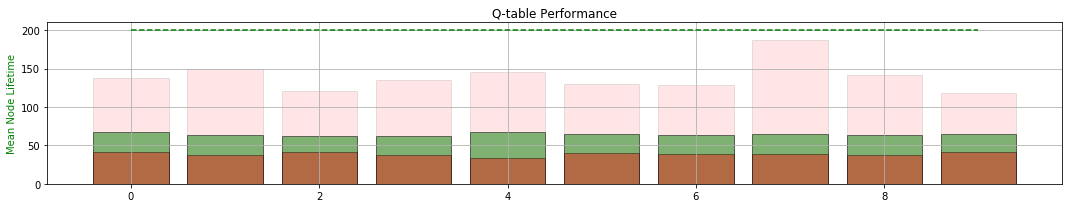

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 125.016	LOSS : 117.901	LOSS : 121.545	LOSS : 150.447	LOSS : 139.106	LOSS : 123.897	LOSS : 143.491	LOSS : 142.572	
Validating... MEAN TIME:  74.35
LOSS : 119.582	LOSS : 142.424	LOSS : 126.006	LOSS : 125.199	LOSS : 130.648	LOSS : 132.355	LOSS : 130.173	LOSS : 118.460	
Validating... MEAN TIME:  81.595
LOSS : 131.943	LOSS : 143.657	LOSS : 136.918	LOSS : 132.459	LOSS : 125.250	LOSS : 128.218	LOSS : 135.165	LOSS : 132.624	
Validating... MEAN TIME:  81.015
LOSS : 118.191	LOSS : 128.522	LOSS : 125.493	LOSS : 145.514	LOSS : 129.611	LOSS : 140.490	LOSS : 118.340	LOSS : 141.204	
Validating... MEAN TIME:  89.435
LOSS : 138.632	LOSS : 125.561	LOSS : 122.804	LOSS : 132.545	LOSS : 140.875	LOSS : 132.808	LOSS : 125.999	LOSS : 125.333	
Validating... MEAN TIME:  85.535
TRAINING TIME:0:00:38.863259


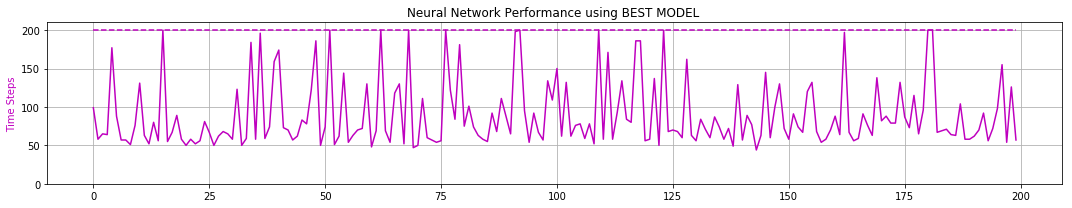

peak memory: 1478.96 MiB, increment: 978.73 MiB
0 -max- [ 0.491  0.930  0.209  1.124]
0 -min- [-0.380 -1.270 -0.209 -0.921]

1 -max- [ 0.470  0.774  0.209  0.781]
1 -min- [-0.360 -1.282 -0.209 -0.808]

2 -max- [ 0.512  0.929  0.208  1.034]
2 -min- [-0.387 -1.268 -0.209 -1.015]

3 -max- [ 0.460  0.767  0.209  0.938]
3 -min- [-0.336 -1.239 -0.209 -0.823]

4 -max- [ 0.481  0.771  0.209  0.763]
4 -min- [-0.388 -1.280 -0.209 -0.791]

5 -max- [ 0.482  0.739  0.208  0.793]
5 -min- [-0.373 -1.261 -0.209 -0.810]

6 -max- [ 0.489  0.750  0.209  0.780]
6 -min- [-0.367 -1.261 -0.209 -0.813]

7 -max- [ 0.482  0.771  0.208  0.798]
7 -min- [-0.349 -1.235 -0.209 -0.930]

8 -max- [ 0.479  0.774  0.209  0.796]
8 -min- [-0.363 -1.230 -0.209 -0.739]

9 -max- [ 0.502  0.741  0.209  0.789]
9 -min- [-0.382 -1.321 -0.209 -1.045]

Quantization TIME:  0.02 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   59971
SMALLEST TIMESTEP: 33
LARGEST  TIMESTEP: 149
TOTAL SERIAL TIMESTEPS:   385864
TOTAL PARALLEL TIME

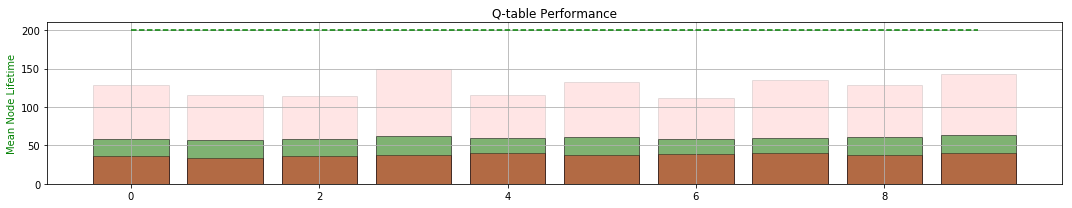

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 134.447	LOSS : 133.255	LOSS : 128.079	LOSS : 140.973	LOSS : 139.696	LOSS : 133.661	LOSS : 147.698	LOSS : 141.792	
Validating... MEAN TIME:  92.67
LOSS : 132.237	LOSS : 126.574	LOSS : 133.769	LOSS : 134.815	LOSS : 141.892	LOSS : 155.921	LOSS : 132.886	LOSS : 125.319	
Validating... MEAN TIME:  105.075
LOSS : 141.839	LOSS : 137.494	LOSS : 130.031	LOSS : 139.197	LOSS : 149.537	LOSS : 130.532	LOSS : 147.338	LOSS : 129.946	
Validating... MEAN TIME:  99.005
LOSS : 126.450	LOSS : 133.556	LOSS : 127.118	LOSS : 136.296	LOSS : 137.429	LOSS : 128.986	LOSS : 137.652	LOSS : 144.172	
Validating... MEAN TIME:  101.685
LOSS : 131.897	LOSS : 142.613	LOSS : 144.977	LOSS : 129.850	LOSS : 136.173	LOSS : 124.672	LOSS : 144.391	LOSS : 143.962	
Validating... MEAN TIME:  105.61
TRAINING TIME:0:00:43.743595


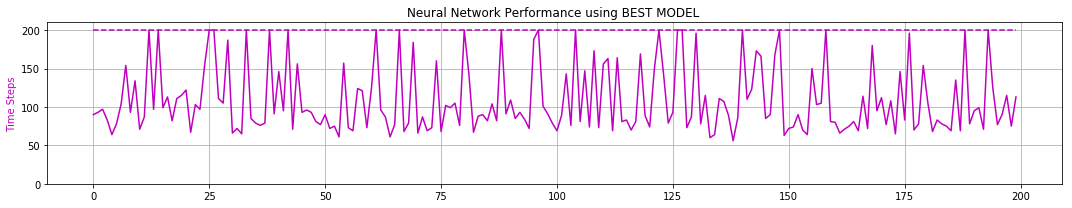

peak memory: 1458.70 MiB, increment: 1015.58 MiB
0 -max- [ 0.214  0.544  0.048  0.391]
0 -min- [-0.267 -1.069 -0.209 -0.921]

1 -max- [ 0.219  0.560  0.050  0.499]
1 -min- [-0.262 -1.117 -0.209 -0.988]

2 -max- [ 0.207  0.572  0.048  0.364]
2 -min- [-0.274 -1.059 -0.209 -0.815]

3 -max- [ 0.236  0.440  0.050  0.467]
3 -min- [-0.271 -1.104 -0.209 -1.023]

4 -max- [ 0.205  0.600  0.049  0.386]
4 -min- [-0.274 -1.071 -0.209 -0.818]

5 -max- [ 0.254  0.439  0.049  0.620]
5 -min- [-0.271 -1.073 -0.209 -0.793]

6 -max- [ 0.205  0.437  0.050  0.404]
6 -min- [-0.251 -0.946 -0.209 -1.060]

7 -max- [ 0.637  0.739  0.200  0.749]
7 -min- [-0.257 -1.048 -0.209 -0.872]

8 -max- [ 0.214  0.747  0.048  0.648]
8 -min- [-0.271 -0.942 -0.209 -1.141]

9 -max- [ 0.300  0.731  0.051  0.434]
9 -min- [-0.245 -1.048 -0.209 -0.992]

Quantization TIME:  0.02 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   63275
SMALLEST TIMESTEP: 38
LARGEST  TIMESTEP: 148
TOTAL SERIAL TIMESTEPS:   449139
TOTAL PARALLEL TIM

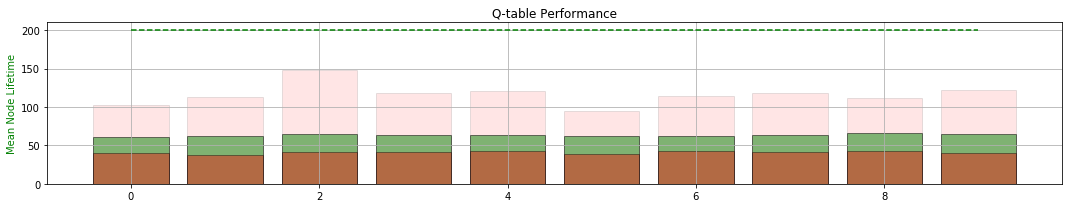

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 144.041	LOSS : 148.979	LOSS : 147.679	LOSS : 148.091	LOSS : 149.132	LOSS : 143.350	LOSS : 126.383	LOSS : 147.359	
Validating... MEAN TIME:  116.93
LOSS : 148.438	LOSS : 130.315	LOSS : 145.765	LOSS : 146.409	LOSS : 140.499	LOSS : 135.247	LOSS : 143.764	LOSS : 134.918	
Validating... MEAN TIME:  132.115
LOSS : 141.774	LOSS : 150.121	LOSS : 139.616	LOSS : 138.006	LOSS : 134.146	LOSS : 131.970	LOSS : 127.655	LOSS : 164.780	
Validating... MEAN TIME:  146.5
LOSS : 156.571	LOSS : 138.664	LOSS : 136.939	LOSS : 152.560	LOSS : 144.066	LOSS : 140.513	LOSS : 151.322	LOSS : 141.642	
Validating... MEAN TIME:  165.135
LOSS : 138.693	LOSS : 151.192	LOSS : 135.304	LOSS : 130.892	LOSS : 143.982	LOSS : 156.008	LOSS : 129.278	LOSS : 144.388	
Validating... MEAN TIME:  180.705
TRAINING TIME:0:00:53.166636


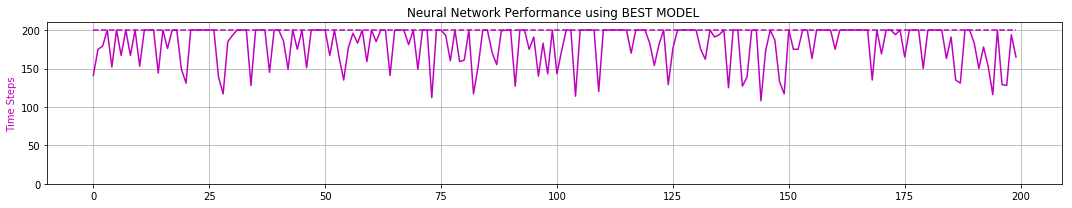

peak memory: 1406.10 MiB, increment: 1017.55 MiB
0 -max- [ 0.205  0.434  0.052  0.645]
0 -min- [-0.288 -1.107 -0.209 -1.012]

1 -max- [ 0.206  0.435  0.048  0.409]
1 -min- [-0.305 -1.136 -0.209 -1.009]

2 -max- [ 0.219  0.591  0.049  0.664]
2 -min- [-0.285 -1.105 -0.209 -0.810]

3 -max- [ 0.198  0.614  0.049  0.486]
3 -min- [-0.316 -1.259 -0.209 -0.959]

4 -max- [ 0.207  0.593  0.049  0.446]
4 -min- [-0.294 -1.082 -0.209 -0.890]

5 -max- [ 0.202  0.596  0.050  0.669]
5 -min- [-0.301 -1.281 -0.209 -1.107]

6 -max- [ 0.225  0.434  0.048  0.406]
6 -min- [-0.282 -1.095 -0.209 -0.803]

7 -max- [ 0.202  0.621  0.049  0.561]
7 -min- [-0.302 -1.088 -0.209 -1.003]

8 -max- [ 0.203  0.433  0.051  0.603]
8 -min- [-0.286 -1.086 -0.209 -0.797]

9 -max- [ 0.205  0.541  0.049  0.439]
9 -min- [-0.309 -1.120 -0.209 -0.824]

Quantization TIME:  0.02 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   87368
SMALLEST TIMESTEP: 55
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   536507
TOTAL PARALLEL TIM

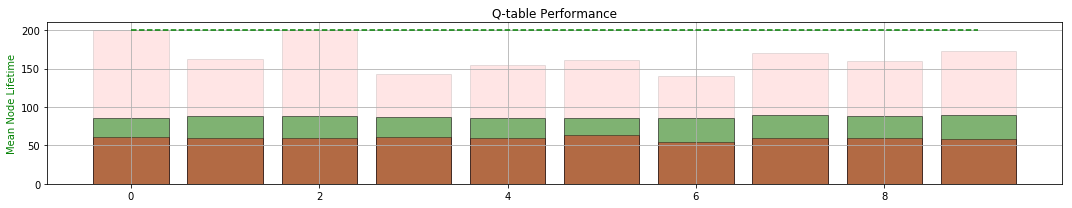

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 137.008	LOSS : 140.974	LOSS : 129.234	LOSS : 135.408	LOSS : 128.644	LOSS : 139.839	LOSS : 128.936	LOSS : 124.541	
Validating... MEAN TIME:  199.9
LOSS : 130.146	LOSS : 116.691	LOSS : 139.349	LOSS : 135.900	LOSS : 138.040	LOSS : 128.654	LOSS : 130.245	LOSS : 130.914	
Validating... MEAN TIME:  200.0
LOSS : 132.851	LOSS : 126.120	LOSS : 126.655	LOSS : 132.286	LOSS : 128.079	LOSS : 129.885	LOSS : 129.910	LOSS : 127.594	
Validating... MEAN TIME:  200.0
LOSS : 124.385	LOSS : 135.505	LOSS : 140.182	LOSS : 137.192	LOSS : 123.211	LOSS : 144.841	LOSS : 125.405	LOSS : 126.256	
Validating... MEAN TIME:  200.0
LOSS : 141.244	LOSS : 135.114	LOSS : 148.027	LOSS : 137.015	LOSS : 136.063	LOSS : 132.508	LOSS : 129.089	LOSS : 140.979	
Validating... MEAN TIME:  200.0
TRAINING TIME:0:01:02.297204


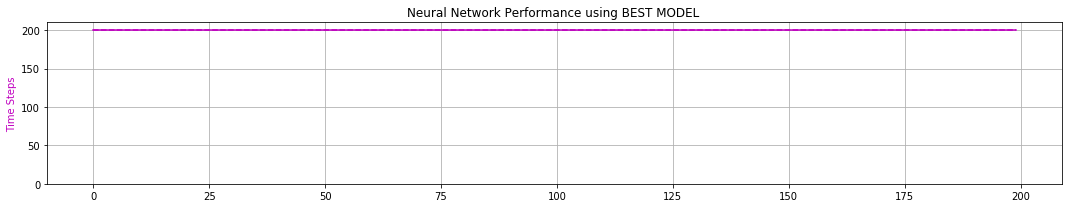

peak memory: 1445.04 MiB, increment: 1036.94 MiB
0 -max- [ 0.939  1.146  0.137  0.593]
0 -min- [-0.620 -1.429 -0.209 -0.865]

1 -max- [ 0.171  0.440  0.049  0.632]
1 -min- [-0.681 -1.439 -0.209 -1.120]

2 -max- [ 1.022  1.128  0.129  0.615]
2 -min- [-0.612 -1.331 -0.209 -1.085]

3 -max- [ 0.180  0.441  0.049  0.667]
3 -min- [-0.613 -1.222 -0.209 -1.118]

4 -max- [ 0.193  0.542  0.050  0.917]
4 -min- [-0.620 -1.252 -0.209 -1.019]

5 -max- [ 0.203  0.589  0.049  0.592]
5 -min- [-0.610 -1.264 -0.209 -1.023]

6 -max- [ 0.159  0.611  0.048  0.628]
6 -min- [-0.628 -1.268 -0.209 -1.047]

7 -max- [ 0.207  0.549  0.051  0.664]
7 -min- [-0.631 -1.267 -0.209 -1.083]

8 -max- [ 0.201  0.431  0.049  0.677]
8 -min- [-0.619 -1.260 -0.209 -0.947]

9 -max- [ 0.187  0.435  0.050  0.677]
9 -min- [-0.614 -1.263 -0.209 -0.943]

Quantization TIME:  0.01 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   199477
SMALLEST TIMESTEP: 134
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   735984
TOTAL PARALLEL T

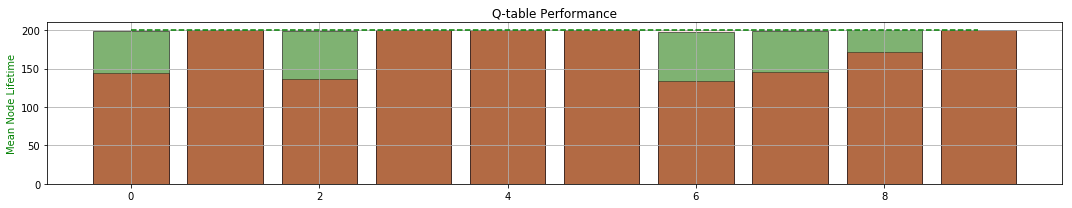

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1641.0
Total Serial Timesteps   :  735984.0
Speed-up                 :  448.50


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS 134   9    1641     735984     448.50
